In [57]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from scipy import stats
import re
import io

# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

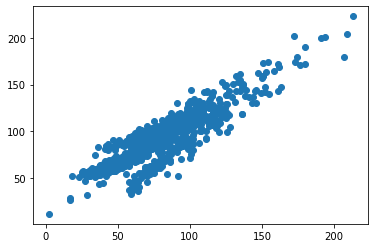

In [2]:
tennis = pd.read_csv("data/tennis.csv")
tennis.head()
tennis.dropna(inplace=True)
y= tennis['player1 total points won']
x = tennis['player2 total points won']
plt.scatter(x,y)
#how to choose the y and the x

In [3]:
est = sm.OLS(y, x).fit()
est.summary()


#t-test
# Coef	std err	t	P>|t|	[0.025	0.975]
# player2 total points won	1.1257	0.006	178.124	0.000	1.113	1.138


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     player1 total points won   R-squared (uncentered):                   0.969
Model:                                  OLS   Adj. R-squared (uncentered):              0.969
Method:                       Least Squares   F-statistic:                          3.173e+04
Date:                      Sat, 16 Jan 2021   Prob (F-statistic):                        0.00
Time:                              11:21:17   Log-Likelihood:                         -4262.4
No. Observations:                      1016   AIC:                                      8527.
Df Residuals:                          1015   BIC:                                      8532.
Df Model:                                 1                                                  
Covariance Type:                  nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
player2 total points won     1.1257      0.006    178.124      0.000       1.113       1.138
==============================================================================
Omnibus:                       71.489   Durbin-Watson:                   1.636
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.456
Skew:                          -0.707   Prob(JB):                     2.78e-19
Kurtosis:                       3.148   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
stats.ttest_ind(x,y)

Ttest_indResult(statistic=-10.142736499527302, pvalue=1.2909773137512344e-23)

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


In [46]:
college = pd.read_csv('data/college.csv')

<AxesSubplot:xlabel='Top25perc', ylabel='Top10perc'>

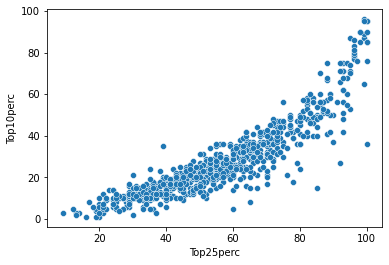

In [47]:
x = college.Top25perc
y = college.Top10perc
sns.scatterplot(data=college,x=x,y=y,)


<AxesSubplot:xlabel='Top25perc', ylabel='Top10perc'>

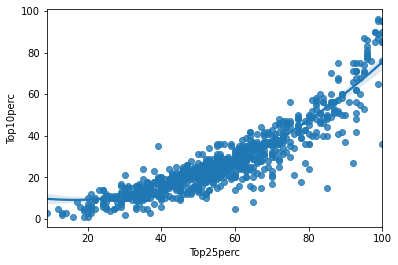

In [48]:
sns.regplot(data=college,x=x,y=y,order=2)

In [49]:
#linear regression  ols
est = sm.OLS(y,x).fit(cov_type='HC2')
print(est.summary())

#AIC 5745
#BIC 5750
#P 0.512  ==> .543


                                 OLS Regression Results                                
Dep. Variable:              Top10perc   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              4351.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):                   2.12e-320
Time:                        12:15:51   Log-Likelihood:                         -2871.5
No. Observations:                 777   AIC:                                      5745.
Df Residuals:                     776   BIC:                                      5750.
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [42]:
#add constant sm. addconstant
X = sm.add_constant(x)
X

,const,Top25perc
0,1.0,52
1,1.0,29
2,1.0,50
3,1.0,89
4,1.0,44
...,...,...
772,1.0,26
773,1.0,47
774,1.0,61
775,1.0,99


In [51]:
#re-do the regression
est1 = sm.OLS(y,X).fit()
print(est1.summary())

#AIC 5434
#BIC 5444
#P .766 AND .823
#sns.scatterplot(data=college,x=x,y=y)

                            OLS Regression Results                            
Dep. Variable:              Top10perc   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     3018.
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          1.87e-269
Time:                        12:17:53   Log-Likelihood:                -2715.2
No. Observations:                 777   AIC:                             5434.
Df Residuals:                     775   BIC:                             5444.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.7725      0.856    -19.588      0.0

In [ ]:
#there is a relation between bot perc because of P


In [56]:
#college.private
#college.private.map

college.private = college.Private.map({"Yes": 1, "No": 0})

y = college.Accept #acceptance rate addmission
x = college.private

x = sm.add_constant(x)

#linear regression
est1 = sm.OLS(y,x).fit()
est1.summary()
#t value and v value if the V value stat import if he goes to private or no

#private school see less addmission the Coef is negative


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Accept   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     226.1
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           4.95e-45
Time:                        12:31:39   Log-Likelihood:                -7066.5
No. Observations:                 777   AIC:                         1.414e+04
Df Residuals:                     775   BIC:                         1.415e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3919.2877    148.212     26.444      0.000    3628.343    4210.233
Private    -2613.5851    173.808    -15.037      0.000   -2954.776   -2272.394
==============================================================================
Omnibus:                      603.909   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15927.055
Skew:                           3.268   Prob(JB):                         0.00
Kurtosis:                      24.195   Cond. No.                         3.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

In [109]:
df_auto = pd.read_csv('data/auto.csv',sep='\s+')
df_auto.dropna(inplace=True)
df_auto.horsepower.replace('?',0,inplace=True)
df_auto.mpg = pd.to_numeric(df_auto.mpg,downcast='float')
df_auto.horsepower = pd.to_numeric(df_auto.horsepower,downcast='float')
#df_auto.dtypes
x = df_auto.horsepower
y = df_auto.mpg
x = sm.add_constant(x)
est = sm.OLS(y,x).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     543.5
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           3.10e-76
Time:                        14:01:57   Log-Likelihood:                -1207.8
No. Observations:                 397   AIC:                             2420.
Df Residuals:                     395   BIC:                             2428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.8792      0.707     55.019      0.0

In [121]:
#1 yes tehre is relation
#2 the relation is strong
#3 the relation is negative
#4 
est.predict([98,1])


array([3810.01562236])

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

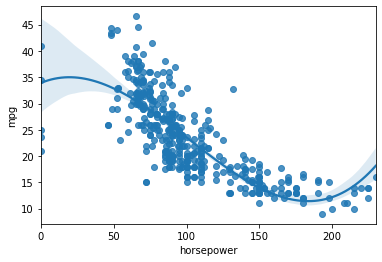

In [128]:
#5
sns.regplot(data=df_auto,x='horsepower',y='mpg',order=3)

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

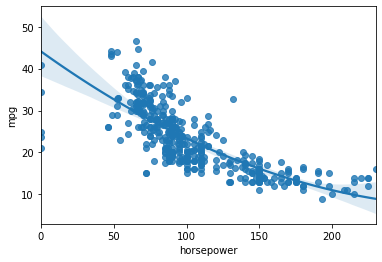

In [131]:
sns.regplot(data=df_auto,x='horsepower',y='mpg',order=2)

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

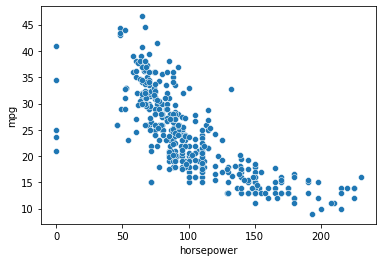

In [130]:
sns.scatterplot(data=df_auto,x='horsepower',y='mpg')

# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

In [140]:
x = df_auto.drop(['name','mpg'],axis=1)
y =  df_auto.mpg
x = sm.add_constant(x)
est = sm.OLS(y,x).fit()#cov_type='HC2'
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     257.0
Date:                Sat, 16 Jan 2021   Prob (F-statistic):          1.28e-141
Time:                        14:45:56   Log-Likelihood:                -1036.8
No. Observations:                 397   AIC:                             2090.
Df Residuals:                     389   BIC:                             2121.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.9640      4.449     -4.038   

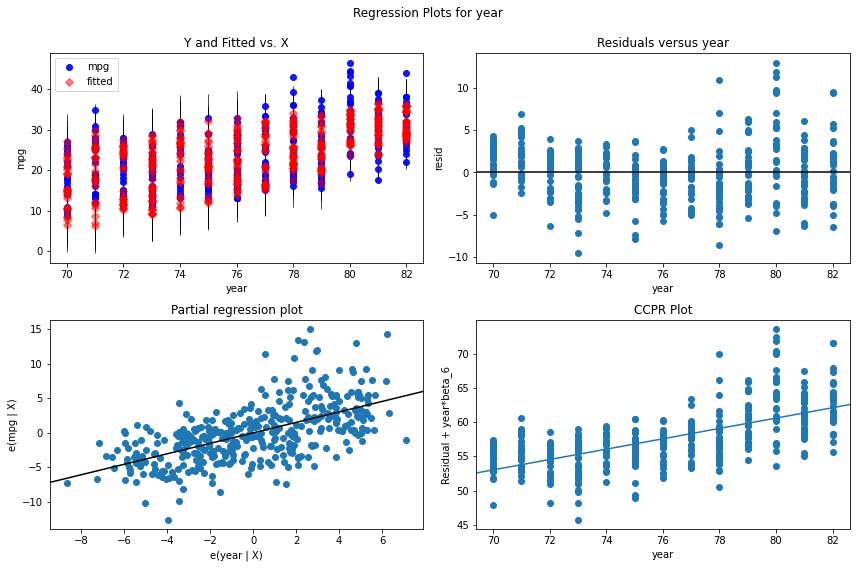

In [144]:
#1 yes, there is a relation
#2 All excep acceleration
#3 mileage improves by 0.7574 every year
#4 Yes, residual plots indicate some structure to the residuals and thereby indicates that the fit is problematic
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(est,'year', fig=fig)
#5 yes, there is heteroscedasticity

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

In [175]:
cs = pd.read_csv('data/carseats.csv')
cs.Urban = cs.Urban.map({"Yes": 1, "No": 0})
cs.US = cs.US.map({"Yes": 1, "No": 0})

x = cs[['Price','Urban','US']]
y = cs.Urban
x = sm.add_constant(x)
est = sm.OLS(y,x).fit()

In [176]:
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  Urban   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.790e+32
Date:                Sat, 16 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:18:42   Log-Likelihood:                 13712.
No. Observations:                 400   AIC:                        -2.742e+04
Df Residuals:                     396   BIC:                        -2.740e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.469e-16    8.3e-17     -4.179      0.0

<Figure size 864x576 with 0 Axes>

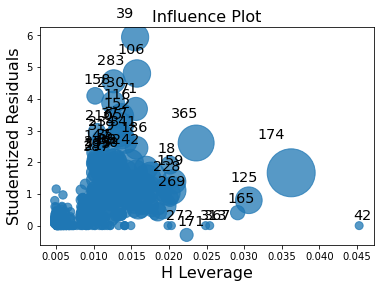

In [181]:
fig = plt.figure(figsize=(12,8))
#fig = sm.graphics.plot_regress_exog(est,'Price', fig=fig)
fig = sm.graphics.influence_plot(est,'Price', fig=fig)

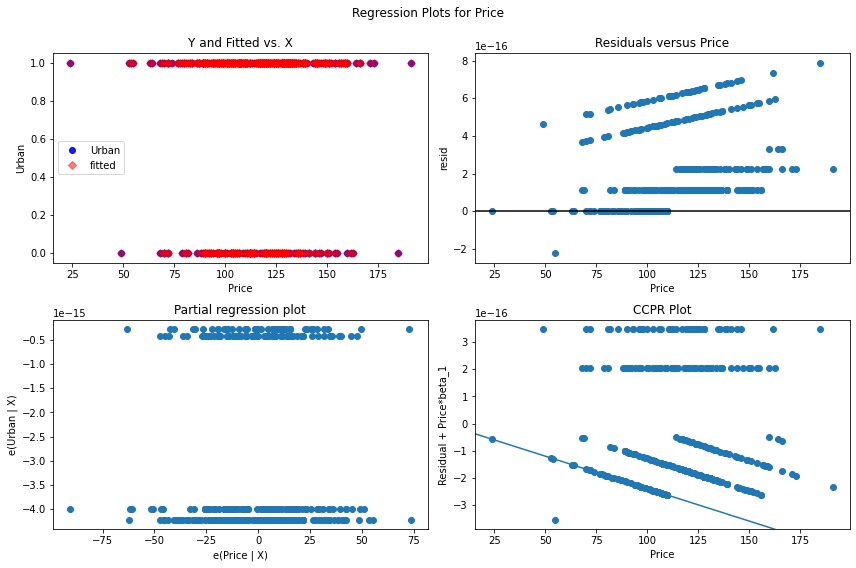

In [185]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(est,'Price', fig=fig)

In [194]:

x = cs[['Price','US']]
y = cs['Sales']
x = sm.add_constant(x)
est1 = sm.OLS(y, x).fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     62.43
Date:                Sat, 16 Jan 2021   Prob (F-statistic):           2.66e-24
Time:                        15:26:07   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.631     20.652      0.0

In [ ]:
#2 
# Price : there is a negative relationship between Price and Sales, where as the Price increases, Sales decrease. This relationship is statistically significant as it has a p-value of 0
# Urban : there is a negative relationship between Urban and Sales. However, this relationship is not statistically significant as it has a p-value greater than 0.1
# US : there is a positive and appreciating relationship between US and Sales. US is a qualitative variable, where if US is true, than the Sales appreciate with a rate of 1.2006


#3 We can reject null hypothesis for Price and US, as the p-values for these variables is 0.000.

#5 Both models fit the data very similarily with the smaller fitting the data marginally better.This can be see in a  lower F-statistic p-value (4.90e-25 vs 4.04e-24 of first model) and marginally lower AIC and BIC values.